In [1]:
import numpy as np
import pandas as pd
from AgentClass import Agent
import const
import random
import networkx as nx
from config import num_agents,number_of_bits
from scipy import stats
from collections import defaultdict
import json
import utilities
import copy

import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib
import seaborn as sns
from random import shuffle

import analysis

from scipy.spatial import distance

In [2]:
def get_tau_distr():
    lower = 0.1
    upper = 1
    mu = 0.5
    sigma = 0.1
    N = 1000

    samples = stats.truncnorm.rvs(
          (lower-mu)/sigma,(upper-mu)/sigma,loc=mu,scale=sigma,size=N)

    return samples

In [3]:
attrctr1 = utilities.bool2int([1,1,1,1,1,1])
attrctr2 = utilities.bool2int([1,1,1,0,0,0])
attrctr3 = utilities.bool2int([0,0,0,1,1,1])

attrctrs = [attrctr1, attrctr2, attrctr3]
attractors = {}
number_attractors = 0
while  number_attractors< 3:
    attractor_state = attrctrs.pop()
    attractor_depth = random.randint(1, number_of_bits) # depth for each attractors is picked randomly
    attractor_radius = random.randint(1, number_of_bits//2)
    
    attractors[attractor_state] = {'depth': attractor_depth, 'radius': attractor_radius}
    number_attractors += 1
attractors 

{56: {'depth': 3, 'radius': 2},
 7: {'depth': 5, 'radius': 2},
 63: {'depth': 3, 'radius': 2}}

In [4]:
def create_environment():
    

    # bits shuffling for equal bits
    
    states = [utilities.int2bool(random.randint(0, 63), number_of_bits) for i in range(num_agents)]
    tau_distr = get_tau_distr()
    list_agents = []
    for i in range(num_agents):
        
        if i%2 ==0:
            in_state = utilities.int2bool(random.choice(list(attractors.keys())), number_of_bits)
        
        else:
            in_state = states.pop()

        a = Agent(name='agent{}'.format(i), tau=random.choice(tau_distr), initial_state=in_state)
        list_agents.append(a)

    # create network
    G = nx.barabasi_albert_graph(num_agents, 5,  seed= 0)
    df = nx.to_pandas_adjacency(G, dtype=int)

    tmp_edges = df.apply(lambda row: row.to_numpy().nonzero()).to_dict()
    edges = {k: v[0].tolist() for k, v in tmp_edges.items()}

    # make random connections with agents
    for k, v in edges.items():
        for ngh in v:
            list_agents[k].add_neighbors(list_agents[ngh])

    return list_agents, G

In [5]:
def get_network_df(list_agents):
    network_df = pd.DataFrame({'Agent Name':[], 'Neighbors':[]})
    for agt in list_agents:
        neighbors = agt.get_neighbors_name()
        network_df = network_df.append({'Agent Name':agt.name,
                                        'Neighbors':neighbors}, ignore_index=True)
    return network_df

In [6]:
def run_simulation(alpha, coherence, bit_mat, list_agents, end_time):
    d = []
    generations = 0
    for t in range(end_time):
        # compute next state for all agents
        for agt in list_agents:
            soc_mat = agt.update_knowledge(alpha, coherence, bit_mat)

        # keep record of current record and all other values
        for agt in list_agents:
            row = {'Agent_Number': int(agt.name.split('t')[1]),
                   'Time':t,
                   # at any time step we will need normalized how many neighbors disagree on bits
                   'bits_disagreement':np.array(agt.state_disagreements),
                   'Current_Knowledge_State':agt.knowledge_state,
                   'Current': utilities.bool2int(agt.knowledge_state),
                   'alpha':alpha,
                   'Next': utilities.bool2int(agt.next_state),
                   'Next_Knowledge_State':agt.next_state}

            d.append(row)

        # now update all agents next state with computed next state
        for agt in list_agents:
            agt.knowledge_state = agt.next_state
            agt.next_state = None
            agt.dissonance_lst = None

        generations+=1

    return pd.DataFrame(d), soc_mat

In [7]:
def hamming(a,b):
    return(bin(a^b).count("1"))

In [8]:
attrctr, inert, coh = analysis.init_coherence_matrix_niraj(attractors, number_of_bits)

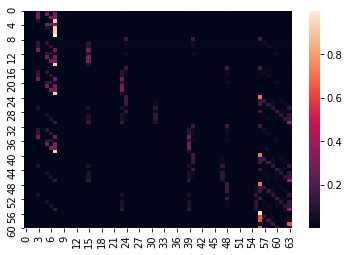

In [9]:
sns.heatmap(coh)

In [10]:
### This cell is for generating the dataset
# constants intialization
import copy
end_simulation_time = 1000
alphas = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0] 
exp_times = 1

# first create environment
agents_list, network_graph = create_environment()

# get network of the agents
agent_network_df = get_network_df(agents_list)
constants = const.Constants()

bit_mat = constants.get_bit_matrix()

record_df = pd.DataFrame()
for i in range(exp_times):
    # run simulation
    for alpha in alphas:

        tmp_record_df, soc_mat = run_simulation(alpha, coh, bit_mat, [copy.copy(a) for a in agents_list], end_simulation_time)
        record_df = record_df.append(tmp_record_df)

Initializing matrix using bitblock method again


In [11]:
tmp = record_df[['Agent_Number', 'Time', 'Current', 'alpha']]
tmp.head()

,Agent_Number,Time,Current,alpha
0,0,0,63,0.0
1,1,0,46,0.0
2,2,0,7,0.0
3,3,0,61,0.0
4,4,0,56,0.0


In [12]:
tmp['state'] = tmp['Current'].apply(lambda row: row if row in attractors else 'NA')
tmp.head()

C:\Users\niraj\AppData\Local\Continuum\anaconda3\envs\probabilistic\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Agent_Number,Time,Current,alpha,state
0,0,0,63,0.0,63
1,1,0,46,0.0,NA
2,2,0,7,0.0,7
3,3,0,61,0.0,NA
4,4,0,56,0.0,56


In [13]:
tmp2 = tmp.groupby(['Time', 'state', 'alpha']).size().to_frame('Agent Count').reset_index()
tmp2

,Time,state,alpha,Agent Count
0,0,7,0.0,87
1,0,7,0.1,87
2,0,7,0.2,87
3,0,7,0.3,87
4,0,7,0.4,87
...,...,...,...,...
43004,999,NA,0.6,327
43005,999,NA,0.7,338
43006,999,NA,0.8,381
43007,999,NA,0.9,401


In [14]:
sns.set(style='darkgrid', rc={'figure.figsize':(15,5)}, font_scale=1.25)

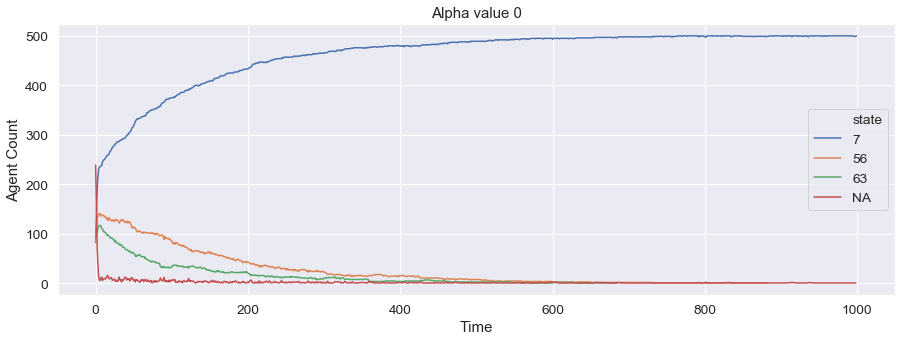

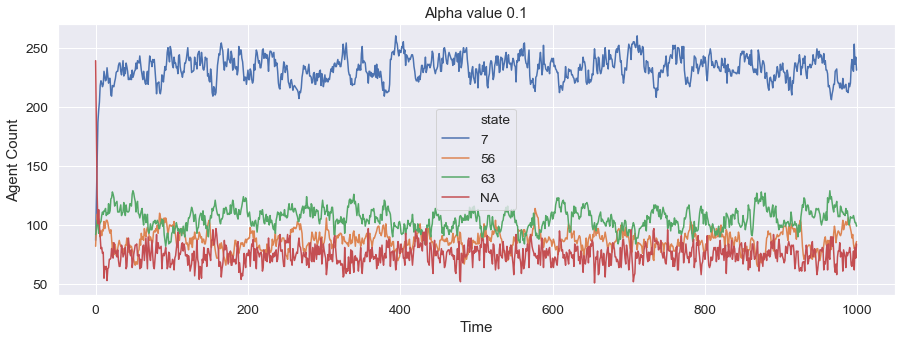

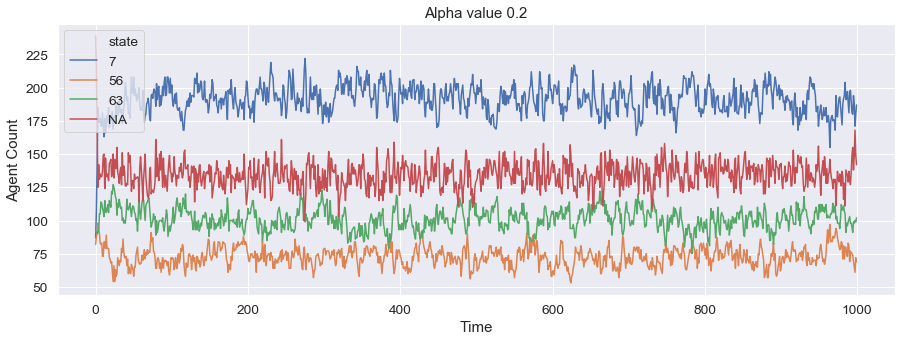

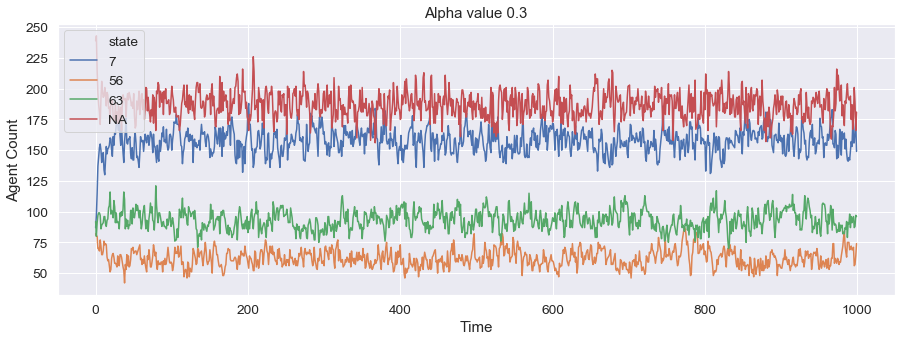

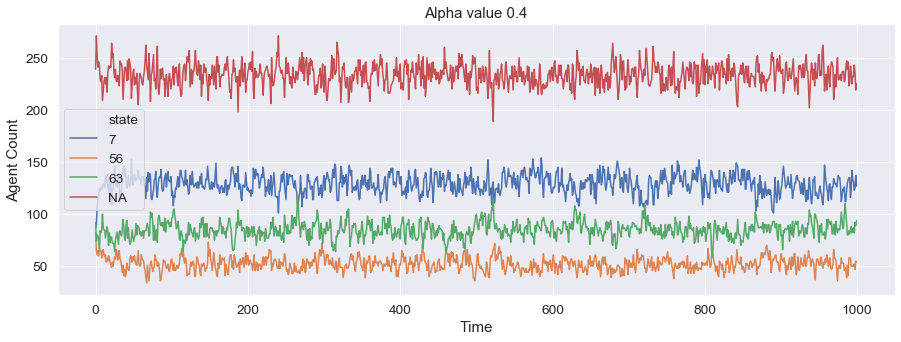

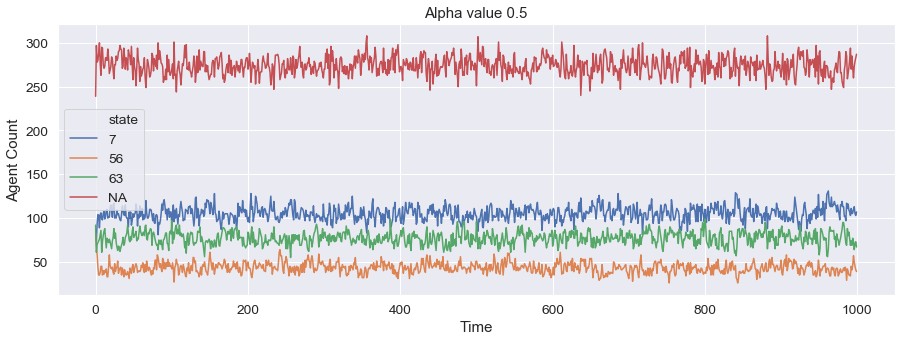

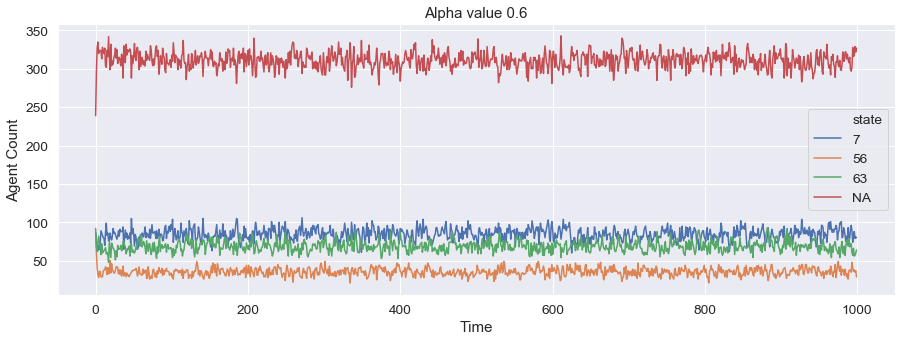

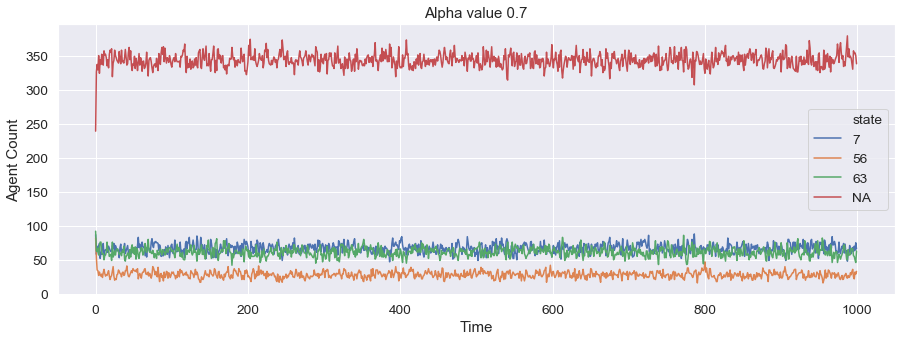

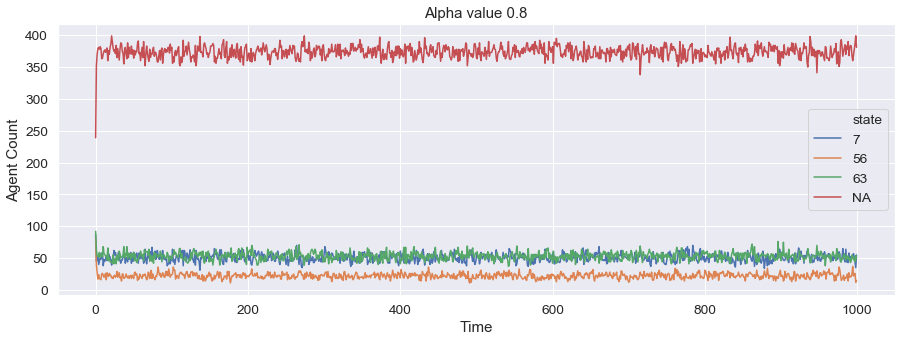

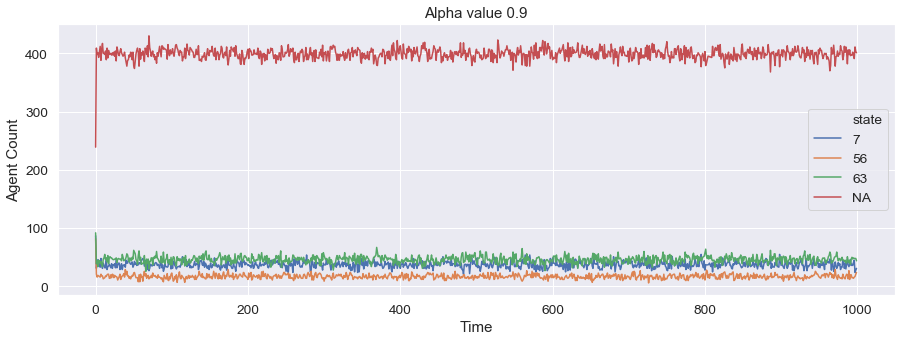

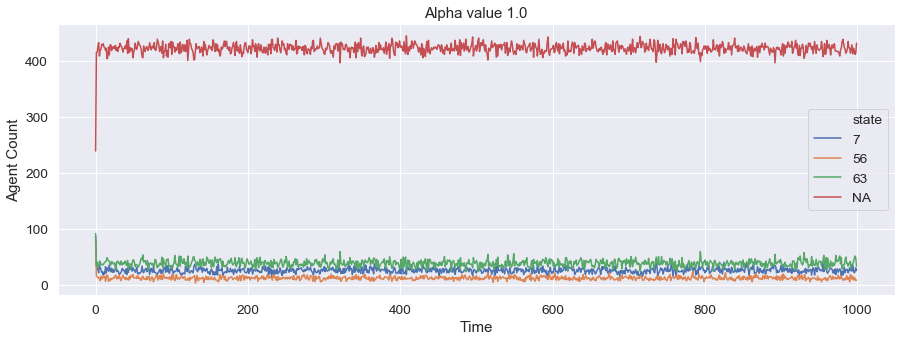

<Figure size 1080x360 with 0 Axes>

In [15]:
for alpha_val in alphas:
    sns.lineplot(x="Time", y="Agent Count", data=tmp2[tmp2['alpha']==alpha_val], hue='state');
    plt.title('Alpha value {}'.format(alpha_val))
    plt.figure();